In [1]:
import os
import torch
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

from src.datasets.speech_dataset import SpeechDataset
from src.models.denoise_net import SpeechDenoiseNet
from src.datasets.silence_dataset import SilenceDataset

In [2]:
dataset = SpeechDataset(train=False)

100%|██████████| 32/32 [00:00<00:00, 7755.56it/s]

Loading validation dataset into memory.
Loading clean data...
Loading noisy data...
Done loading dataset into memory.


# Experiments

- found audo clip start offsets were random - threw out older experiments
- trained both MSE and FL on silence - worked OK
- trained both MSE and FL on pass through (clean -> clean) - worked OK
- tried to overfit small net on 1 batch - mostly just pass through
- scaled up overfit net with MSE loss (100 epochs)
  - 3 inner layers / 64 channels
      - training
        - loss diverges early from MSE 0.002 to 0.006 by epoch 4
        - plateus for ~8 epochs
        - slowly decreases to 0.0017 over ~90 epochs
      - output
        - legible, slightly distored, sounds a little clippy?
        - waveform looks ok
        - fine grained spectral details maintained
  - 8 / 64: 
      - training diverges from 0.0014 to 0.005 in ~10 epochs
      - plateaus for ~20 epochs
      - doesn't really come down after that
      - waveform looks noiser
      - speech not legible
  - 12/ 64:
 - scaled up overfit net with FL loss
   - 3 inner layers, 64 channels
       - training
         - loss diverges early from 7 to 30 in first 10 epochs
         - plateus for ~10 epochs
         - slowly reduces to 16, MSE down to 0.0012 (slightly beating MSE loss)
       - output
         - waveform looks good!
         - fine grained spectral detail mostly conserved
         - noise is less
         - voice a little splashly   
   - 8 inner layers, 64 channels
       - training
         - loss diverges early from 7 to 30 in first 10 epochs
         - plateus for ~10 epochs
         - slowly decreases to 24. MSE to 0.0045
   - 12

In [3]:
CHECKPOINT = 'denoise-net-1570771097.ckpt'
net = SpeechDenoiseNet().cpu()
net.eval()
net.training
net.load_state_dict(torch.load(os.path.join('checkpoints', CHECKPOINT)))

<All keys matched successfully>

In [4]:
def visualize_results(arr, s):
    print(s)
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    fig.set_size_inches(12,12)
    ax1.plot(arr)
    ax2.specgram(arr, Fs=16000)    
    plt.show()
    return Audio(arr, rate=16000)

def get_results(idx):
    in_wav_arr = dataset[idx][0].numpy()
    clean_wav_arr = dataset[idx][1].numpy()
    inputs = torch.tensor(in_wav_arr).float().cpu()
    inputs = inputs.view(1, 1, -1)
    outputs = net(inputs)
    outputs = outputs.squeeze(dim=0)
    wav_arr = outputs.cpu().detach().numpy()
    return wav_arr, in_wav_arr, clean_wav_arr

In [5]:
wav_arr, in_wav_arr, clean_wav_arr = get_results(5)

/home/matt/code/speech-enhancement/speech-enhancement/env/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Predicted clean signal


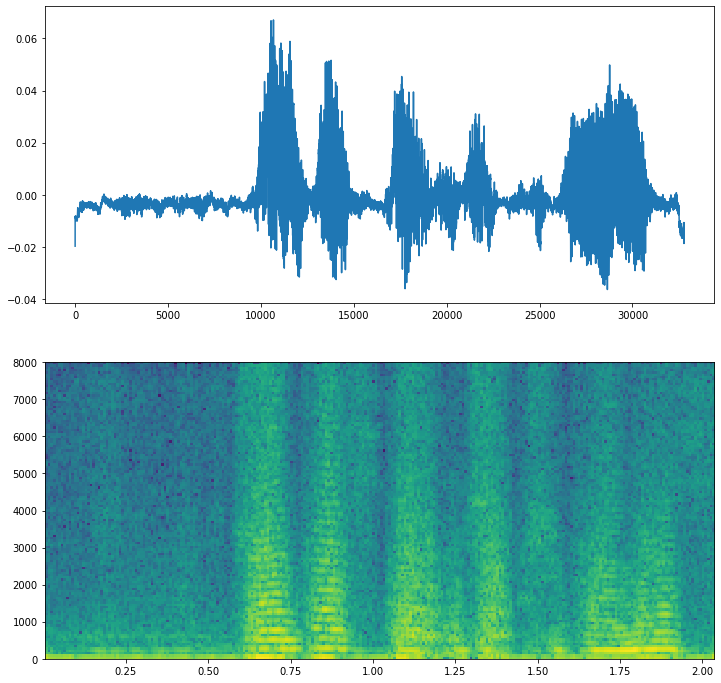

In [6]:
visualize_results(wav_arr, 'Predicted clean signal')

Noisy signal


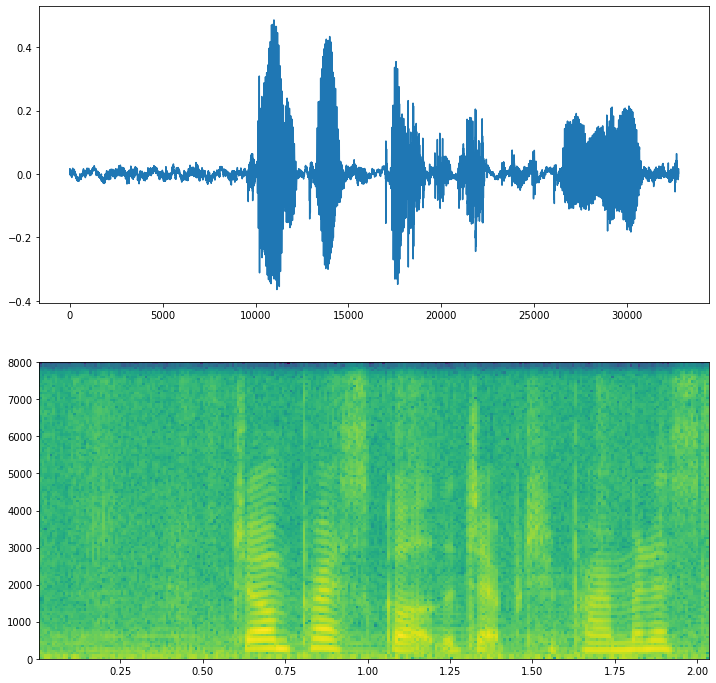

In [7]:
visualize_results(in_wav_arr, 'Noisy signal')

Clean signal


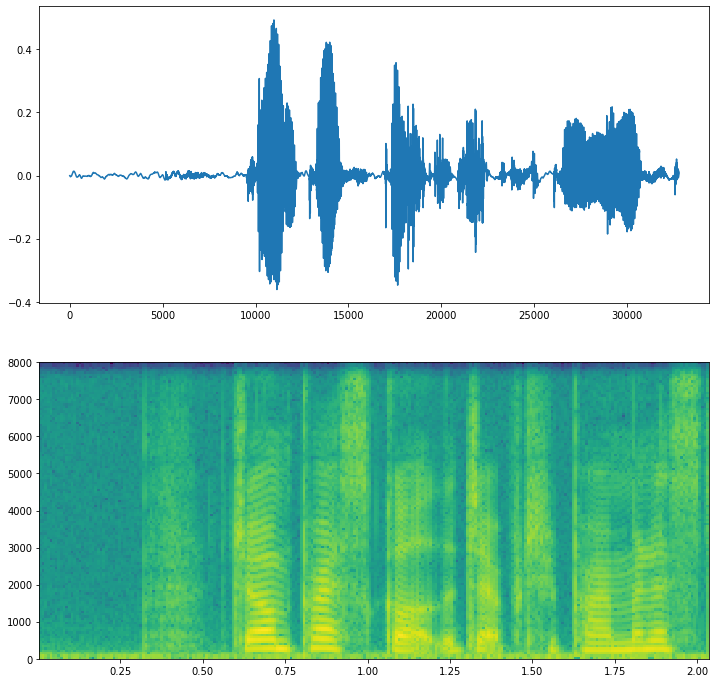

In [8]:
visualize_results(clean_wav_arr, 'Clean signal')